In [1]:
import pandas as pd
from datasets import load_dataset
from fastpunct import FastPunct
import re
from keybert import KeyBERT
from nltk.tag import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import nltk
nltk.download('wordnet')
import spacy
import numpy as np
import itertools
import yake
import matplotlib.pyplot as plt
import math  
import sklearn.metrics

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Raghav\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
dataset_train = load_dataset("stsb_multi_mt", name="en", split="train")
print("Training Dataset :-", dataset_train)

dataset_test = load_dataset("stsb_multi_mt", name="en", split="test")
print("Testing Dataset :-", dataset_test)

Found cached dataset stsb_multi_mt (C:/Users/Raghav/.cache/huggingface/datasets/stsb_multi_mt/en/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)


Training Dataset :- Dataset({
    features: ['sentence1', 'sentence2', 'similarity_score'],
    num_rows: 5749
})


Found cached dataset stsb_multi_mt (C:/Users/Raghav/.cache/huggingface/datasets/stsb_multi_mt/en/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)


Testing Dataset :- Dataset({
    features: ['sentence1', 'sentence2', 'similarity_score'],
    num_rows: 1379
})


# Loading the Training Dataset :- stsb-multi-mt-main/data/stsb-en-train

In [3]:
path = "C:/Users/Raghav/Downloads/stsb-multi-mt-main/stsb-multi-mt-main/data/"

trainingData = pd.read_csv(path + "stsb-en-train.csv", names = ['sentence1', 'sentence2', 'similarity_score'])
trainingData

sentence1  \
0                                A plane is taking off.   
1                       A man is playing a large flute.   
2         A man is spreading shreded cheese on a pizza.   
3                          Three men are playing chess.   
4                           A man is playing the cello.   
...                                                 ...   
5744         Severe Gales As Storm Clodagh Hits Britain   
5745  Dozens of Egyptians hostages taken by Libyan t...   
5746                       President heading to Bahrain   
5747         China, India vow to further bilateral ties   
5748   Putin spokesman: Doping charges appear unfounded   

                                              sentence2  similarity_score  
0                           An air plane is taking off.              5.00  
1                             A man is playing a flute.              3.80  
2     A man is spreading shredded cheese on an uncoo...              3.80  
3                            Two men are playing chess.              2.60  
4                    A man seated is playing the cello.              4.25  
...                                                 ...               ...  
5744         Merkel pledges NATO solidarity with Latvia              0.00  
5745  Egyptian boat crash death toll rises as more b...              0.00  
5746  President Xi: China to continue help to fight ...              0.00  
5747  China Scrambles to Reassure Jittery Stock Traders              0.00  
5748  The Latest on Severe Weather: 1 Dead in Texas ...              0.00  

[5749 rows x 3 columns]

# Loading the Testing Dataset :- stsb-multi-mt-main/data/stsb-en-test

In [4]:
testingData = pd.read_csv (path + 'stsb-en-test.csv', names = ['sentence1', 'sentence2', 'similarity_score'])
testingData

sentence1  \
0                           A girl is styling her hair.   
1              A group of men play soccer on the beach.   
2         One woman is measuring another woman's ankle.   
3                       A man is cutting up a cucumber.   
4                              A man is playing a harp.   
...                                                 ...   
1374  Philippines, Canada pledge to further boost re...   
1375  Israel bars Palestinians from Jerusalem's Old ...   
1376         How much do you know about Secret Service?   
1377  Obama Struggles to Soothe Saudi Fears As Iran ...   
1378          South Korea declares end to MERS outbreak   

                                              sentence2  similarity_score  
0                          A girl is brushing her hair.               2.5  
1      A group of boys are playing soccer on the beach.               3.6  
2               A woman measures another woman's ankle.               5.0  
3                          A man is slicing a cucumber.               4.2  
4                          A man is playing a keyboard.               1.5  
...                                                 ...               ...  
1374            Philippines saves 100 after ferry sinks               0.0  
1375  Two-state solution between Palestinians, Israe...               1.0  
1376  Lawmakers from both sides express outrage at S...               1.0  
1377  Myanmar Struggles to Finalize Voter Lists for ...               0.0  
1378  North Korea Delegation Meets With South Korean...               0.0  

[1379 rows x 3 columns]

In [5]:
text1 = trainingData['sentence1'][2000]
text2 = trainingData['sentence2'][2000]
ss = trainingData['similarity_score'][2000]

text1 = text1.lower()
text2 = text2.lower()

print(text1)
print(text2)
print(ss)

how about some testimonies from real health experts?
also, who's to say there aren't testimonies from "real" health experts on there?
3.0


In [6]:
R_patterns = [
   (r'won\'t', 'will not'),
   (r'can\'t', 'can not'),
   (r'(\w+)\'m', '\g<1> am'),
   (r'(\w+)\'ll', '\g<1> will'),
   (r'(\w+)\'d like to', '\g<1> would like to'),
   (r'(\w+)n\'t', '\g<1> not'),
   (r'(\w+)\'ve', '\g<1> have'),
   (r'(\w+)\'s', '\g<1> is'),
   (r'(\w+)\'re', '\g<1> are')
]

class REReplacer(object):
   def __init__(self, patterns = R_patterns):
      self.patterns = [(re.compile(regex), repl) for (regex, repl) in R_patterns]
   def replace(self, text):
      s = text
      for (pattern, repl) in self.patterns:
         s = re.sub(pattern, repl, s)
      return s

In [7]:
rep_word = REReplacer()

In [8]:
text1 = rep_word.replace(text1)
text2 = rep_word.replace(text2)

print(text1)
print(text2)

how about some testimonies from real health experts?
also, who is to say there are not testimonies from "real" health experts on there?


In [9]:
def text_lower(x):
    return x.lower()

def normalize(x):
    return x/5

trainingData['sentence1'] = trainingData['sentence1'].apply(text_lower)
trainingData['sentence2'] = trainingData['sentence2'].apply(text_lower)
trainingData['similarity_score'] = trainingData['similarity_score'].apply(normalize)

trainingData['sentence1'] = trainingData['sentence1'].apply(rep_word.replace)
trainingData['sentence2'] = trainingData['sentence2'].apply(rep_word.replace)

trainingData

sentence1  \
0                                a plane is taking off.   
1                       a man is playing a large flute.   
2         a man is spreading shreded cheese on a pizza.   
3                          three men are playing chess.   
4                           a man is playing the cello.   
...                                                 ...   
5744         severe gales as storm clodagh hits britain   
5745  dozens of egyptians hostages taken by libyan t...   
5746                       president heading to bahrain   
5747         china, india vow to further bilateral ties   
5748   putin spokesman: doping charges appear unfounded   

                                              sentence2  similarity_score  
0                           an air plane is taking off.              1.00  
1                             a man is playing a flute.              0.76  
2     a man is spreading shredded cheese on an uncoo...              0.76  
3                            two men are playing chess.              0.52  
4                    a man seated is playing the cello.              0.85  
...                                                 ...               ...  
5744         merkel pledges nato solidarity with latvia              0.00  
5745  egyptian boat crash death toll rises as more b...              0.00  
5746  president xi: china to continue help to fight ...              0.00  
5747  china scrambles to reassure jittery stock traders              0.00  
5748  the latest on severe weather: 1 dead in texas ...              0.00  

[5749 rows x 3 columns]

In [10]:
def replace_punct(x):
    pattern = "[^\w\d\.\+\*\-\\\=\s\?]"   
    repl = ""
    
    return re.sub(pattern, repl, x)

text1 = replace_punct(text1)
text2 = replace_punct(text2)

print(text1)
print(text2)

how about some testimonies from real health experts?
also who is to say there are not testimonies from real health experts on there?


In [11]:
trainingData['sentence1'] = trainingData['sentence1'].apply(rep_word.replace)
trainingData['sentence2'] = trainingData['sentence2'].apply(rep_word.replace)

trainingData['sentence1'] = trainingData['sentence1'].apply(replace_punct)
trainingData['sentence2'] = trainingData['sentence2'].apply(replace_punct)

trainingData['sentence1'] = trainingData['sentence1'].apply(text_lower)
trainingData['sentence2'] = trainingData['sentence2'].apply(text_lower)

trainingData

sentence1  \
0                                a plane is taking off.   
1                       a man is playing a large flute.   
2         a man is spreading shreded cheese on a pizza.   
3                          three men are playing chess.   
4                           a man is playing the cello.   
...                                                 ...   
5744         severe gales as storm clodagh hits britain   
5745  dozens of egyptians hostages taken by libyan t...   
5746                       president heading to bahrain   
5747          china india vow to further bilateral ties   
5748    putin spokesman doping charges appear unfounded   

                                              sentence2  similarity_score  
0                           an air plane is taking off.              1.00  
1                             a man is playing a flute.              0.76  
2     a man is spreading shredded cheese on an uncoo...              0.76  
3                            two men are playing chess.              0.52  
4                    a man seated is playing the cello.              0.85  
...                                                 ...               ...  
5744         merkel pledges nato solidarity with latvia              0.00  
5745  egyptian boat crash death toll rises as more b...              0.00  
5746  president xi china to continue help to fight e...              0.00  
5747  china scrambles to reassure jittery stock traders              0.00  
5748  the latest on severe weather 1 dead in texas a...              0.00  

[5749 rows x 3 columns]

In [12]:
kw_model = KeyBERT()
keywords_text1_keybert = kw_model.extract_keywords(text1)
keywords_text2_keybert = kw_model.extract_keywords(text2)
print(keywords_text1_keybert)
print(keywords_text2_keybert)

[('testimonies', 0.6033), ('health', 0.4202), ('experts', 0.223), ('real', 0.153)]
[('testimonies', 0.5322), ('health', 0.3734), ('experts', 0.2959), ('real', 0.1481), ('say', 0.0973)]


In [13]:
language = "en"
max_ngram_size = 1
deduplication_threshold = 0.9
deduplication_algo = 'seqm'
windowSize = 2
numOfKeywords = 101

custom_kw_extractor = yake.KeywordExtractor(lan=language, 
                                            n=max_ngram_size, 
                                            dedupLim=deduplication_threshold, 
                                            dedupFunc=deduplication_algo, 
                                            windowsSize=windowSize, 
                                            top=numOfKeywords, 
                                            features=None)
keywords_text1_yake = custom_kw_extractor.extract_keywords(text1)
keywords_text2_yake = custom_kw_extractor.extract_keywords(text2)

print(keywords_text1_yake)
print(keywords_text2_yake)

[('experts', 0.15831692877998726), ('testimonies', 0.29736558256021506), ('real', 0.29736558256021506), ('health', 0.29736558256021506)]
[('testimonies', 0.15831692877998726), ('real', 0.15831692877998726), ('health', 0.15831692877998726), ('experts', 0.15831692877998726)]


In [14]:
def keybert_keywordExtractor(text):
    
    kw_model = KeyBERT()
    return kw_model.extract_keywords(text)
    
def yake_keywordExtractor(text, language = "en", max_ngram_size = 1, deduplication_threshold = 0.9, deduplication_algo = 'seqm', windowSize = 2, numOfKeywords = 101):
    
    custom_kw_extractor = yake.KeywordExtractor(lan = language, 
                                            n = max_ngram_size, 
                                            dedupLim = deduplication_threshold, 
                                            dedupFunc = deduplication_algo, 
                                            windowsSize = windowSize, 
                                            top = numOfKeywords, 
                                            features = None)
    
    return custom_kw_extractor.extract_keywords(text)


In [15]:
trainingData['keybert_keys_sentence1'] = trainingData['sentence1'].apply(keybert_keywordExtractor)
trainingData['keybert_keys_sentence2'] = trainingData['sentence2'].apply(keybert_keywordExtractor)

trainingData['yake_keys_sentence1'] = trainingData['sentence1'].apply(yake_keywordExtractor)
trainingData['yake_keys_sentence2'] = trainingData['sentence2'].apply(yake_keywordExtractor)

trainingData

sentence1  \
0                                a plane is taking off.   
1                       a man is playing a large flute.   
2         a man is spreading shreded cheese on a pizza.   
3                          three men are playing chess.   
4                           a man is playing the cello.   
...                                                 ...   
5744         severe gales as storm clodagh hits britain   
5745  dozens of egyptians hostages taken by libyan t...   
5746                       president heading to bahrain   
5747          china india vow to further bilateral ties   
5748    putin spokesman doping charges appear unfounded   

                                              sentence2  similarity_score  \
0                           an air plane is taking off.              1.00   
1                             a man is playing a flute.              0.76   
2     a man is spreading shredded cheese on an uncoo...              0.76   
3                            two men are playing chess.              0.52   
4                    a man seated is playing the cello.              0.85   
...                                                 ...               ...   
5744         merkel pledges nato solidarity with latvia              0.00   
5745  egyptian boat crash death toll rises as more b...              0.00   
5746  president xi china to continue help to fight e...              0.00   
5747  china scrambles to reassure jittery stock traders              0.00   
5748  the latest on severe weather 1 dead in texas a...              0.00   

                                 keybert_keys_sentence1  \
0                   [(plane, 0.6741), (taking, 0.2064)]   
1     [(flute, 0.6614), (large, 0.2601), (playing, 0...   
2     [(cheese, 0.4431), (pizza, 0.428), (shreded, 0...   
3     [(chess, 0.5606), (men, 0.2698), (playing, 0.1...   
4     [(cello, 0.725), (playing, 0.1964), (man, 0.08...   
...                                                 ...   
5744  [(storm, 0.4813), (gales, 0.4223), (clodagh, 0...   
5745  [(hostages, 0.5942), (terrorists, 0.4757), (li...   
5746  [(bahrain, 0.6418), (president, 0.3659), (head...   
5747  [(vow, 0.3717), (ties, 0.2891), (bilateral, 0....   
5748  [(doping, 0.5277), (putin, 0.4016), (unfounded...   

                                 keybert_keys_sentence2  \
0     [(plane, 0.6193), (air, 0.3708), (taking, 0.17...   
1     [(flute, 0.7156), (playing, 0.2152), (man, 0.0...   
2     [(cheese, 0.4711), (pizza, 0.4439), (uncooked,...   
3     [(chess, 0.6004), (men, 0.2258), (playing, 0.2...   
4     [(cello, 0.6644), (playing, 0.2387), (seated, ...   
...                                                 ...   
5744  [(latvia, 0.559), (nato, 0.541), (merkel, 0.45...   
5745  [(nile, 0.5281), (egyptian, 0.3372), (toll, 0....   
5746  [(ebola, 0.5988), (xi, 0.3394), (china, 0.2673...   
5747  [(traders, 0.4677), (jittery, 0.4364), (scramb...   
5748  [(tornado, 0.5628), (texas, 0.362), (weather, ...   

                                    yake_keys_sentence1  \
0     [(plane, 0.29736558256021506), (taking, 0.2973...   
1     [(flute, 0.09568045026443411), (man, 0.1583169...   
2     [(pizza, 0.09568045026443411), (man, 0.1583169...   
3     [(chess, 0.15831692877998726), (men, 0.2973655...   
4     [(cello, 0.15831692877998726), (man, 0.2973655...   
...                                                 ...   
5744  [(severe, 0.15831692877998726), (britain, 0.15...   
5745  [(dozens, 0.15831692877998726), (airstrikes, 0...   
5746  [(president, 0.15831692877998726), (bahrain, 0...   
5747  [(china, 0.15831692877998726), (ties, 0.158316...   
5748  [(putin, 0.15831692877998726), (unfounded, 0.1...   

                                    yake_keys_sentence2  
0     [(air, 0.29736558256021506), (plane, 0.2973655...  
1     [(flute, 0.09568045026443411), (man, 0.1583169...  
2     [(pizza, 0.15831692877998726), (man, 0.2973655...  
3     [(chess, 0.15831692877998726), (men, 0.2973655.

# Main Scoring Logic

In [16]:
def scoring_unit(keywords_text1, keywords_text2):
    match = 0
    total = 0
    synonym_dict = []
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    for token in keywords_text1:
        total += token[1]
    
    if(total == 0):
        return 1
    
    for var in keywords_text2:
        syn = wordnet.synsets(var[0])
        syn_words = [x.lemma_names() for x in syn]
        syn_words = [x for elem in syn_words for x in elem]
        syn_words.append(var[0])
        syn_words = list(set(syn_words))
        #print(syn_words)
        temp = []
        wt = word_tokenize(var[0])
        pos = pos_tag(wt)[0][1]
        for i in range(0, len(syn_words)):
            checker_wt = word_tokenize(syn_words[i])
            checker_pos = pos_tag(wt)[0][1]
            if(pos == checker_pos):
                temp.append(syn_words[i])
        synonym_dict = synonym_dict + temp
    #print(synonym_dict)
    
    for token in keywords_text1:
        syn = wordnet.synsets(token[0])
        syn_words = [x.lemma_names() for x in syn]
        syn_words = [x for elem in syn_words for x in elem]
        syn_words.append(token[0])
        syn_words = list(set(syn_words))
        if len(set(syn_words).intersection(set(synonym_dict)))!=0:
            print(token[0])
            match += token[1]
            
    return(match/total)

In [17]:
trainingData['keybert_score'] = trainingData[['keybert_keys_sentence1',
                                              'keybert_keys_sentence2']].apply(lambda x:scoring_unit(x.keybert_keys_sentence1, 
                                                                                                     x.keybert_keys_sentence2), 
                                                                                                        axis=1)
trainingData['yake_score'] = trainingData[['yake_keys_sentence1',
                                              'yake_keys_sentence2']].apply(lambda x:scoring_unit(x.yake_keys_sentence1, 
                                                                                                     x.yake_keys_sentence2), 
                                                                                                        axis=1)

trainingData

plane
taking
flute
playing
man
cheese
pizza
shreded
spreading
chess
men
playing
cello
playing
man
fighting
men
man
playing
man
singing
guitar
playing
cat
throwing
ceiling
person
stick
man
kangaroo
woman
holds
picks
flute
playing
man
folding
paper
piece
running
road
bacon
dog
trying
bear
sliding
snow
polar
woman
cat
rubbing
baby
horse
riding
man
pot
pours
man
guitar
playing
panda
slide
sliding
eating
woman
potato
peels
woman
bike
fell
boy
flute
woman
playing
rabbit
eagle
running
pork
chop
breaded
woman
kite
flying
girl
bull
mechanical
riding
man
guitar
playing
man
singing
women
woman
dancing
slicing
man
pouring
oil
man
lion
playing
skateboard
dog
rides
statue
carving
onion
shrimp
peels
woman
fish
woman
guitar
woman
playing
playing
baby
slicing
person
onion
cuts
person
playing
playing
cutting
man
guitar
playing
guitar
playing
guitar
playing
playing
boy
guitar
playing
man
licks
dog
baby
onion
playing
man
pepper
woman
drums
playing
man
horse
woman
rides
banana
eating
man
playing
axe
chops


sentence1  \
0                                a plane is taking off.   
1                       a man is playing a large flute.   
2         a man is spreading shreded cheese on a pizza.   
3                          three men are playing chess.   
4                           a man is playing the cello.   
...                                                 ...   
5744         severe gales as storm clodagh hits britain   
5745  dozens of egyptians hostages taken by libyan t...   
5746                       president heading to bahrain   
5747          china india vow to further bilateral ties   
5748    putin spokesman doping charges appear unfounded   

                                              sentence2  similarity_score  \
0                           an air plane is taking off.              1.00   
1                             a man is playing a flute.              0.76   
2     a man is spreading shredded cheese on an uncoo...              0.76   
3                            two men are playing chess.              0.52   
4                    a man seated is playing the cello.              0.85   
...                                                 ...               ...   
5744         merkel pledges nato solidarity with latvia              0.00   
5745  egyptian boat crash death toll rises as more b...              0.00   
5746  president xi china to continue help to fight e...              0.00   
5747  china scrambles to reassure jittery stock traders              0.00   
5748  the latest on severe weather 1 dead in texas a...              0.00   

                                 keybert_keys_sentence1  \
0                   [(plane, 0.6741), (taking, 0.2064)]   
1     [(flute, 0.6614), (large, 0.2601), (playing, 0...   
2     [(cheese, 0.4431), (pizza, 0.428), (shreded, 0...   
3     [(chess, 0.5606), (men, 0.2698), (playing, 0.1...   
4     [(cello, 0.725), (playing, 0.1964), (man, 0.08...   
...                                                 ...   
5744  [(storm, 0.4813), (gales, 0.4223), (clodagh, 0...   
5745  [(hostages, 0.5942), (terrorists, 0.4757), (li...   
5746  [(bahrain, 0.6418), (president, 0.3659), (head...   
5747  [(vow, 0.3717), (ties, 0.2891), (bilateral, 0....   
5748  [(doping, 0.5277), (putin, 0.4016), (unfounded...   

                                 keybert_keys_sentence2  \
0     [(plane, 0.6193), (air, 0.3708), (taking, 0.17...   
1     [(flute, 0.7156), (playing, 0.2152), (man, 0.0...   
2     [(cheese, 0.4711), (pizza, 0.4439), (uncooked,...   
3     [(chess, 0.6004), (men, 0.2258), (playing, 0.2...   
4     [(cello, 0.6644), (playing, 0.2387), (seated, ...   
...                                                 ...   
5744  [(latvia, 0.559), (nato, 0.541), (merkel, 0.45...   
5745  [(nile, 0.5281), (egyptian, 0.3372), (toll, 0....   
5746  [(ebola, 0.5988), (xi, 0.3394), (china, 0.2673...   
5747  [(traders, 0.4677), (jittery, 0.4364), (scramb...   
5748  [(tornado, 0.5628), (texas, 0.362), (weather, ...   

                                    yake_keys_sentence1  \
0     [(plane, 0.29736558256021506), (taking, 0.2973...   
1     [(flute, 0.09568045026443411), (man, 0.1583169...   
2     [(pizza, 0.09568045026443411), (man, 0.1583169...   
3     [(chess, 0.15831692877998726), (men, 0.2973655...   
4     [(cello, 0.15831692877998726), (man, 0.2973655...   
...                                                 ...   
5744  [(severe, 0.15831692877998726), (britain, 0.15...   
5745  [(dozens, 0.15831692877998726), (airstrikes, 0...   
5746  [(president, 0.15831692877998726), (bahrain, 0...   
5747  [(china, 0.15831692877998726), (ties, 0.158316...   
5748  [(putin, 0.15831692877998726), (unfounded, 0.1...   

                                    yake_keys_sentence2  keybert_score  \
0     [(air, 0.29736558256021506), (plane, 0.2973655...       1.000000   
1     [(flute, 0.09568045026443411), (man, 0.1583169...       0.784543   
2     [(pizza, 0.15831692877998726), (man, 0.2973655...       0

In [18]:
trainingData.to_csv(r'C:\Users\Raghav\Desktop\file4.csv')

In [19]:
display(trainingData.iloc[25])

sentence1                                        the boy fell off his bike.
sentence2                                         a boy falls off his bike.
similarity_score                                                       0.96
keybert_keys_sentence1       [(bike, 0.386), (fell, 0.3597), (boy, 0.2348)]
keybert_keys_sentence2      [(bike, 0.4057), (falls, 0.3738), (boy, 0.223)]
yake_keys_sentence1       [(bike, 0.15831692877998726), (boy, 0.29736558...
yake_keys_sentence2       [(bike, 0.15831692877998726), (boy, 0.29736558...
keybert_score                                                           1.0
yake_score                                                              1.0
Name: 25, dtype: object

<Figure size 432x288 with 0 Axes>

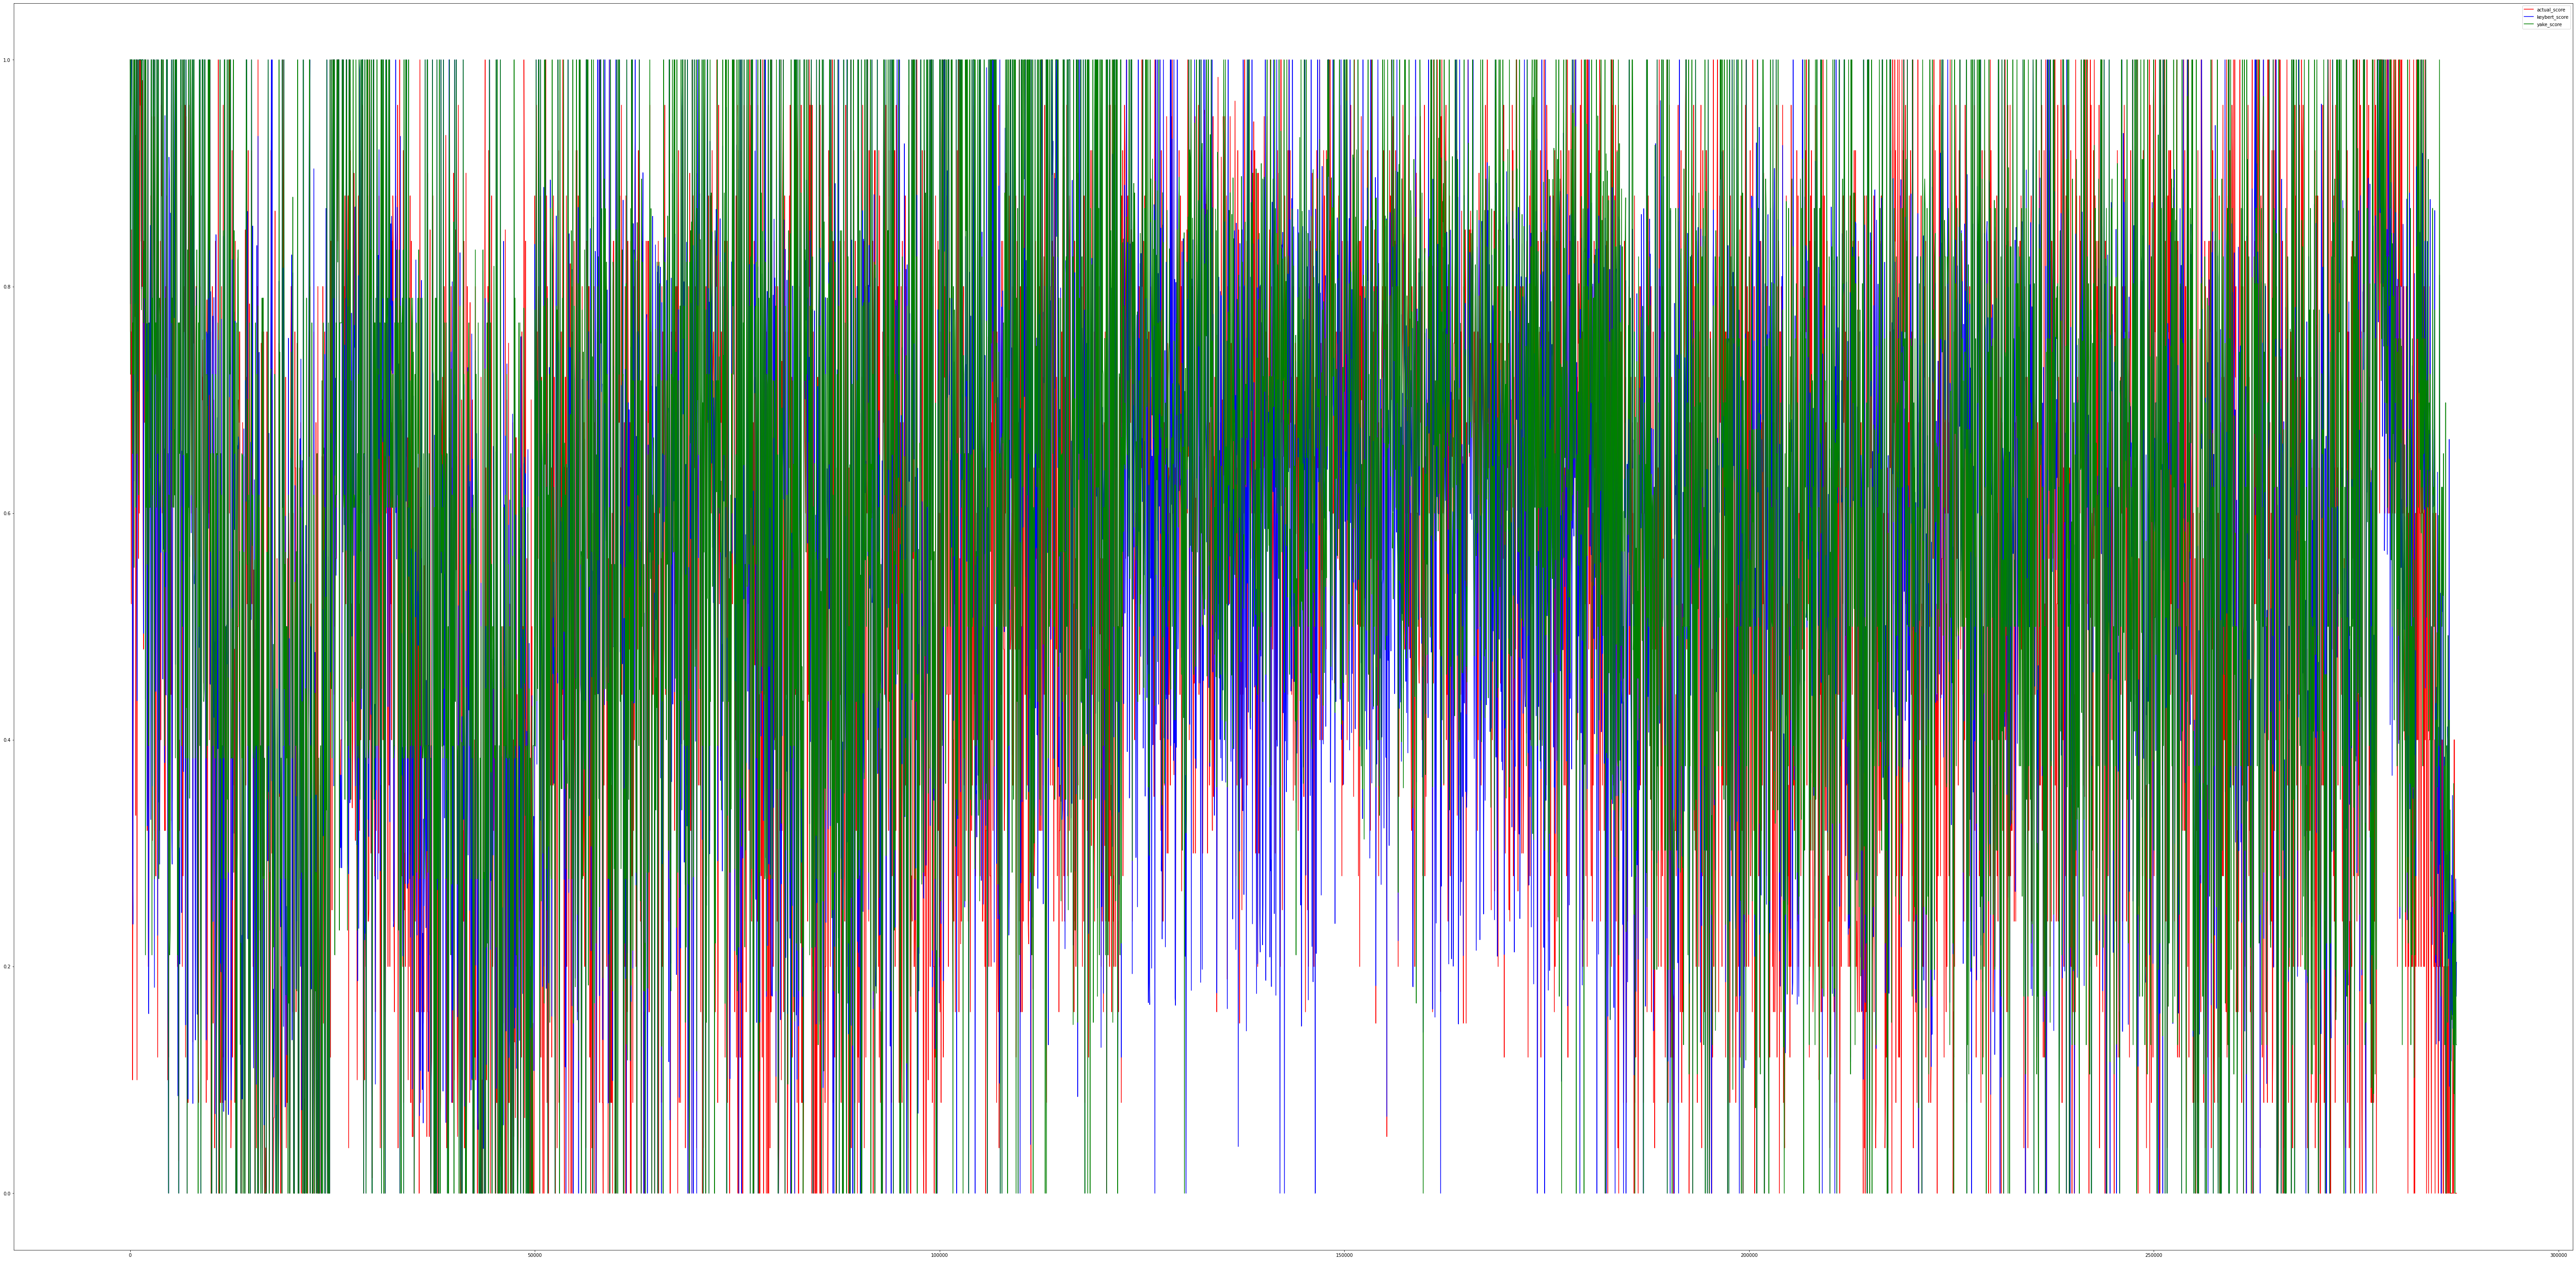

In [20]:
plt.clf()
plt.figure(figsize=(100,50))

plt.plot([i for i in range(1, (len(trainingData))*50, 50)], trainingData['similarity_score'], color='r', label='actual_score')
plt.plot([i for i in range(1, (len(trainingData))*50, 50)] , trainingData['keybert_score'], color='b', label='keybert_score')
plt.plot([i for i in range(1, (len(trainingData))*50, 50)] , trainingData['yake_score'], color='g', label='yake_score')
          
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

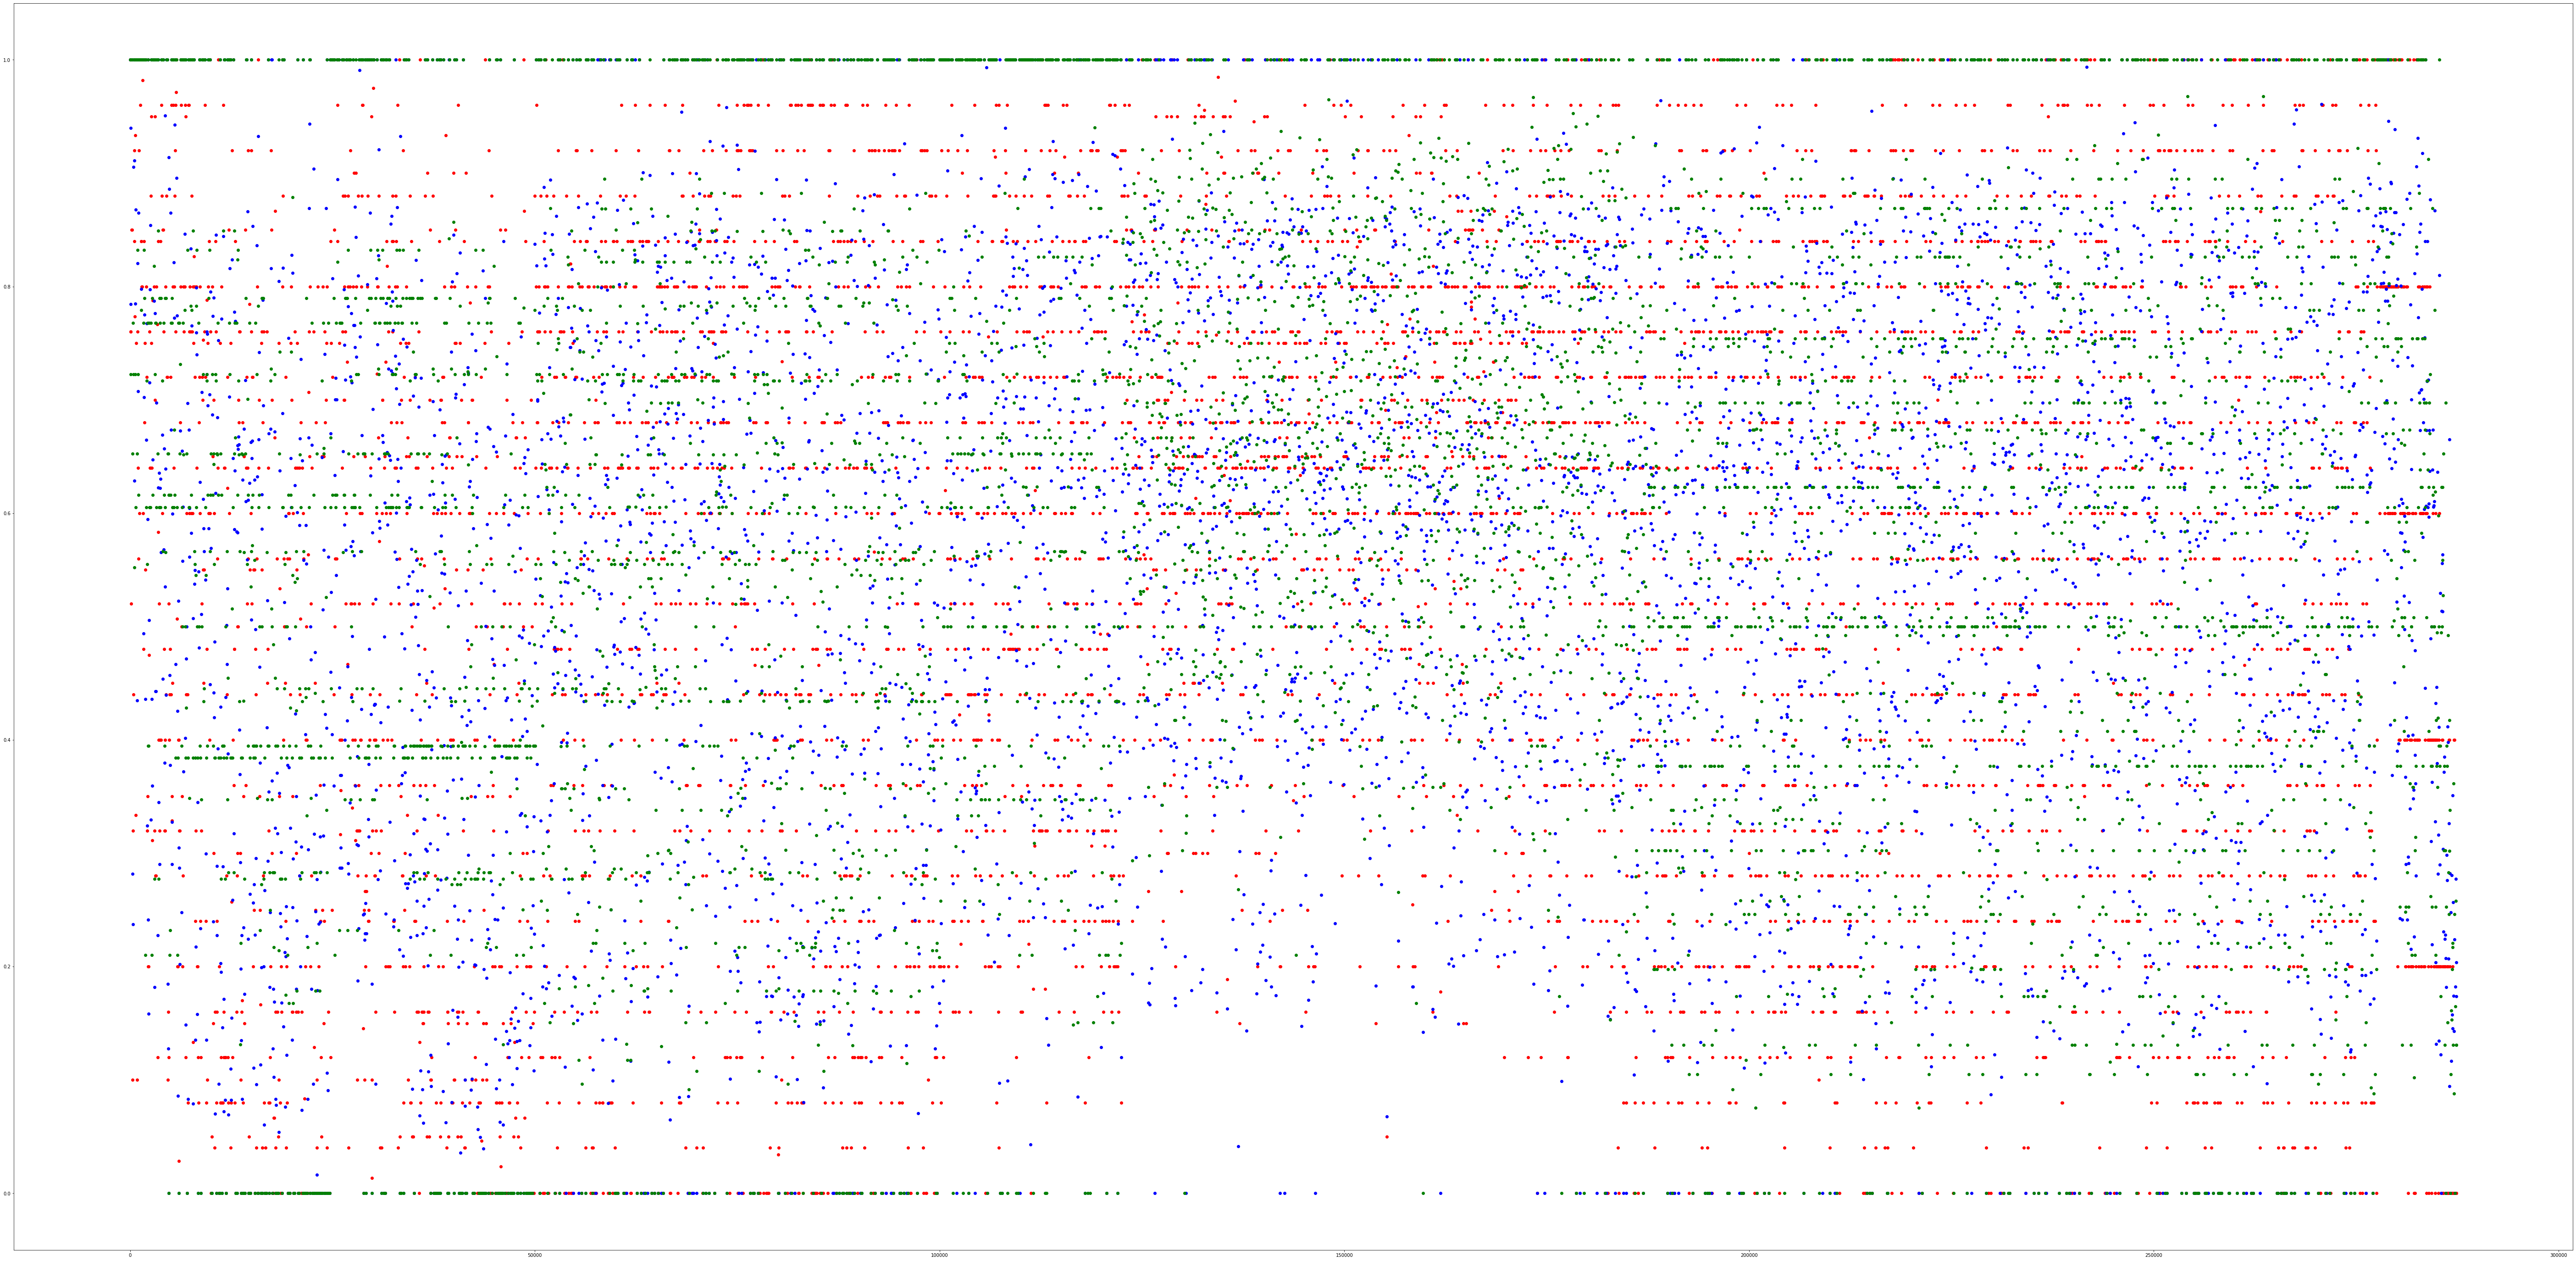

In [21]:
plt.clf()
plt.figure(figsize=(100,50))

plt.scatter([i for i in range(1, (len(trainingData))*50, 50)], trainingData['similarity_score'], color='r', marker='o')
plt.scatter([i for i in range(1, (len(trainingData))*50, 50)] , trainingData['keybert_score'], color='b', marker='o')
plt.scatter([i for i in range(1, (len(trainingData))*50, 50)] , trainingData['yake_score'], color='g', marker='o')

plt.show()

In [22]:
mse_keybert = sklearn.metrics.mean_squared_error(trainingData['similarity_score'], trainingData['keybert_score'])  
rmse_keybert = math.sqrt(mse_keybert)  

print("The difference between actual and keybert values", rmse_keybert)  

The difference between actual and keybert values 0.2261632092908743


In [23]:
mse_yake = sklearn.metrics.mean_squared_error(trainingData['similarity_score'], trainingData['yake_score'])  
rmse_yake = math.sqrt(mse_yake)  

print("The difference between actual and yake values", rmse_yake)  

The difference between actual and yake values 0.24595982205364356
